# machine learning
## this is a demo to show the advantage of multitask learning.

In [1]:
import sys
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import datetime

import chainer
from chainer import cuda
chainer.global_config.autotune = True 

sys.path.append("../MIGraph/GraphConv/")
sys.path.append("../MIGraph/Train/")

from GGNN import GGNN
from Config import Config
from AutoParameterScaling import AutoParameterScaling
from GraphNNPredictor import GraphNNPredictor,formatDataset,myConcat

CF=Config()


In [3]:
#load dataset
alldataset= joblib.load("bin/traindataset.bin")

#for faster learning, minibatch was set to be 128
miniBatch=128
print("minibatch: ",miniBatch)

#50% of pedot-pss database will be trained
SPL_RATIO=0.5

#first 332 cases are pedot in alldataset, rests are wiki
PEDOTCases=332

minibatch:  128


# define utility functions for sindle-mode and multitask training

In [4]:
from chainer.iterators import SerialIterator

def prepDataset():
    global trainDataset, testDataset
    #if you want to learn only PEDOT-PSS database, run this code
    if multiMode is not True:   
        print("single mode")
        pedotDataset= alldataset[:PEDOTCases]
        split_at = int(len(pedotDataset) * SPL_RATIO)
        trainDataset, testDataset = chainer.datasets.split_dataset_random(pedotDataset, split_at)

    #if you want multitask learning, run this code
    else:
        #split dataset. Here, splitting is done in an tricky way to check the efficiency of multitask learn. (see our paper)
        print("multitask mode")
        split_at = int(len(alldataset[:PEDOTCases]) * SPL_RATIO)
        trainDataset, testDataset = chainer.datasets.split_dataset_random(alldataset[:PEDOTCases], split_at)
        otherTrainDataset, _ = chainer.datasets.split_dataset_random(alldataset[PEDOTCases:], len(alldataset[PEDOTCases:]))
        trainDataset=trainDataset[:]+otherTrainDataset[:]
        trainDataset,_= chainer.datasets.split_dataset_random(trainDataset,len(trainDataset))

    global train_iter,test_iter
    train_iter= SerialIterator(formatDataset(trainDataset), miniBatch)
    test_iter = SerialIterator(formatDataset(testDataset),1,False,False)

    print("test: ",len(testDataset))
    print("train: ",len(trainDataset))

    #get labels for prediction
    _,_,_,learnLabels=zip(*alldataset)
    print("params:", list(set(learnLabels)))

In [5]:
#set up model
from chainer import optimizers
from chainer import training
from chainer.training import extensions
from chainer import serializers

def train():
    global ggnn
    ggnn=GraphNNPredictor()

    if CF.GPUMode:
        cuda.get_device(CF.gpu_device).use()
        ggnn.to_gpu(CF.gpu_device)
        print("gpu mode")

    #optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(ggnn)
    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=CF.gpu_device,converter=myConcat)

    #trainer (early stopping can be used, but 100 epoch is good)
    max_epoch = 100

    #ML seems much faster without validation (at least, in author's environment)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='res')
    trainer.extend(extensions.LogReport())
    #trainer.extend(extensions.Evaluator(test_iter, ggnn, device=CF.gpu_device))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',  'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss','validation/main/loss'], x_key='epoch', file_name='loss.png'))

    trainer.run()



In [6]:
from AnalyzeUtility import AnalyzeUtility
import seaborn as sns


#as default, only electric conductivity is plotted for clarity.
#you can change "target" to predict other parameters.
def analyze(target="electric conductivity",plotHeatMap=True, plotTest=True):
    #load scalers and data analyzer
    autoscaler=joblib.load("praparingGraphs/output/AutoSC.scaler")
    analUtil=AnalyzeUtility(autoscaler,ggnn)

    ggnn.outFingeprint=False
    
    #train
    print("train score")
    _,_,_,nodeTypeList=list(zip(*trainDataset))
    selData=[data for data,typ in zip(trainDataset,nodeTypeList) if typ==target]
    y,t=analUtil.predictByGGNN_batch(formatDataset(selData))
    x,y=analUtil.plot(t,y,None,target)

    #test
    if plotTest:
        print("test score")
        _,_,_,nodeTypeList=list(zip(*testDataset))
        selData=[data for data,typ in zip(testDataset,nodeTypeList) if typ==target]
        y,t=analUtil.predictByGGNN_batch(formatDataset(selData))
        x,y=analUtil.plot(t,y,None,target)

    #visualize latent vectors. this may take time.
    if plotHeatMap:
        ggnn.outFingeprint=True
        trainX,trainY=analUtil.predictByGGNN_batch(formatDataset(alldataset[:1000]))

        sc = StandardScaler()
        trainX = sc.fit_transform(trainX)
        
        plt.figure(figsize=(20, 10))
        sns.heatmap(trainX,cmap="Spectral")

# below are the results!
# train only 50% of PEDOT-PSS database
- electric conductivity is plotted
- internal output of the network is plotted
    - Data 0-331 come from PEDOT-PSS. rests are wiki.

In [7]:
multiMode=False
prepDataset()
train()
analyze(target='electric conductivity',plotHeatMap=True,plotTest=True)

single mode
test:  166
train:  166
params: ['band gap', 'density', 'electric conductivity', 'refractive index', 'absolute standard enthalpy of formation', 'pka', 'partition coefficient', 'molar heat capacity', 'thermal conductivity', 'absolute molar magnetic susceptibility', 'dipole moment', 'vapor pressure', 'boiling temperature', 'melting temperature', 'heat capacity', 'viscosity']


RuntimeError: CUDA environment is not correctly set up
(see https://github.com/chainer/chainer#installation).No module named 'cupy.util'

AttributeError: 'object' object has no attribute 'util'

# train 50% of PEDOT-PSS database and full of Wikipedia database
- you can see that accuracy is much improved by multitask training.
- internal outputs become similar, comparing those of PEDOT-PSS and wiki, due to multitask learning

multitask mode
test:  166
train:  3835
params: ['vapor pressure', 'viscosity', 'band gap', 'electric conductivity', 'partition coefficient', 'molar heat capacity', 'thermal conductivity', 'dipole moment', 'pka', 'melting temperature', 'absolute molar magnetic susceptibility', 'density', 'boiling temperature', 'absolute standard enthalpy of formation', 'heat capacity', 'refractive index']
gpu mode
epoch       main/loss   validation/main/loss  elapsed_time
1           0.905916                          0.803768      
2           0.800184                          1.6645        
3           0.744778                          2.53553       
4           0.708255                          3.41195       
5           0.659131                          4.31078       
6           0.66653                           5.2131        
7           0.646224                          6.12223       
8           0.642363                          7.02059       
9           0.594471                          7.92098

  0%|          | 0/32 [00:00<?, ?it/s]

train score
R2:  0.6602988699126081
MAE:  0.41524592
test score
R2:  0.520522129807488
MAE:  0.53112835


100%|██████████| 32/32 [00:00<00:00, 116.99it/s]


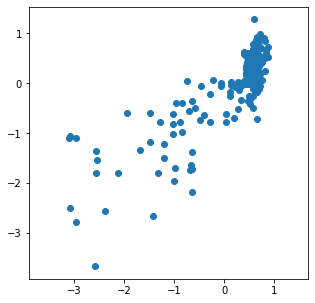

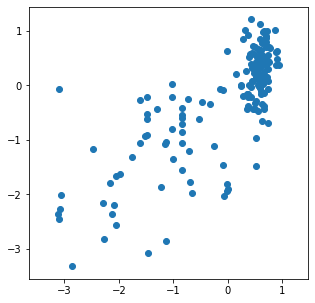

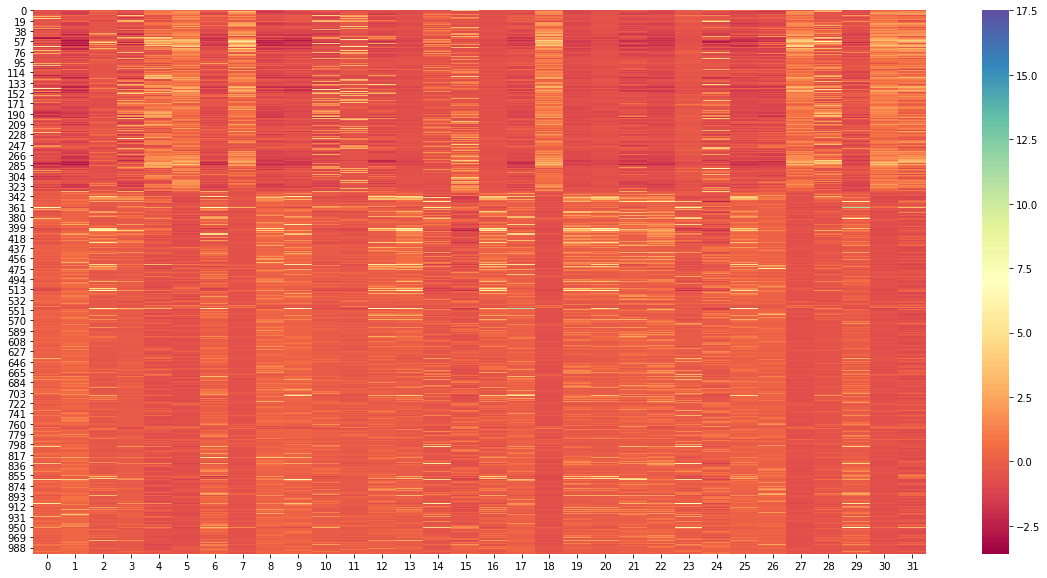

In [9]:
multiMode=True
prepDataset()
train()
analyze(target='electric conductivity',plotHeatMap=True,plotTest=True)


100%|██████████| 2/2 [00:00<00:00, 115.45it/s]

vapor pressure
train score
R2:  0.9367259557381807
MAE:  0.44141242


viscosity
train score
R2:  0.9676259772149384
MAE:  0.16633801


band gap
train score
R2:  0.8669220947630817
MAE:  0.32444093


partition coefficient
train score
R2:  0.949357273938028
MAE:  0.34368518


molar heat capacity
train score



  0%|          | 0/40 [00:00<?, ?it/s]

R2:  0.8950755146050083
MAE:  13.397958


thermal conductivity
train score
R2:  0.8708449096996185
MAE:  0.40082192


dipole moment
train score
R2:  0.9291552802352504
MAE:  0.24032965


pka
train score
R2:  0.9158656830324282
MAE:  0.9358839


melting temperature
train score


  0%|          | 0/24 [00:00<?, ?it/s]

R2:  0.9185869696084387
MAE:  76.40691


absolute molar magnetic susceptibility
train score
R2:  0.8747465856396108
MAE:  0.19154063


density
train score


 55%|█████▍    | 12/22 [00:00<00:00, 66.81it/s] 

R2:  0.8847460804698627
MAE:  0.38555306


boiling temperature
train score



100%|██████████| 6/6 [00:00<00:00, 118.07it/s]


R2:  0.9292358380154255
MAE:  92.4515


absolute standard enthalpy of formation
train score
R2:  0.9628146548384527
MAE:  85.583


heat capacity
train score
R2:  0.8394596082241215
MAE:  20.956362


refractive index
train score
R2:  0.9144081317412904
MAE:  0.17709132




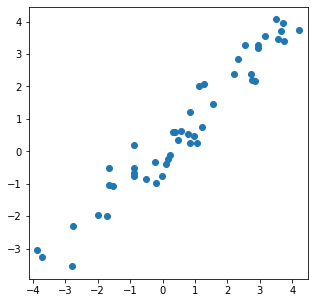

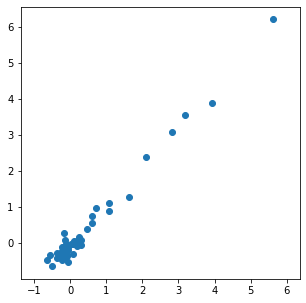

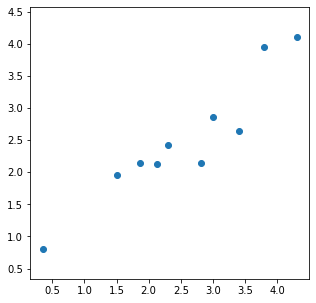

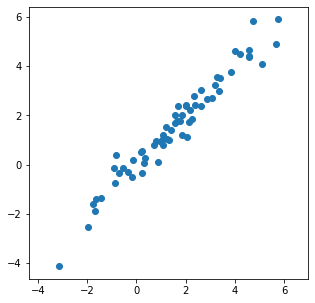

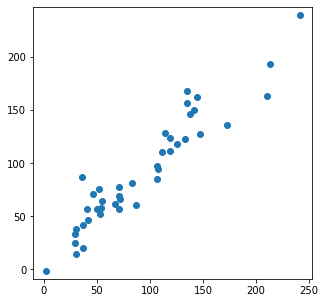

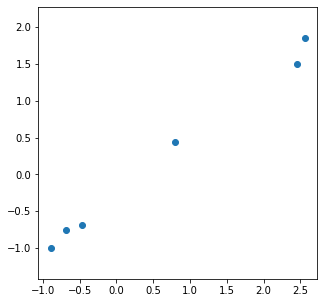

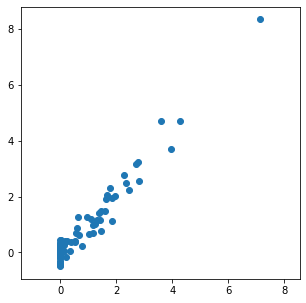

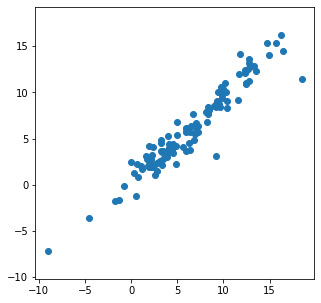

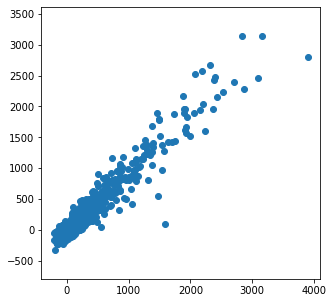

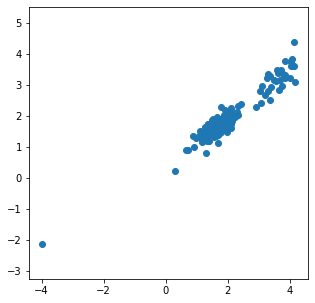

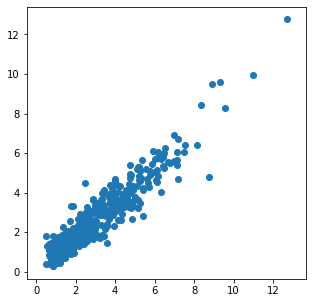

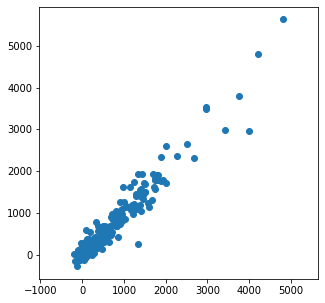

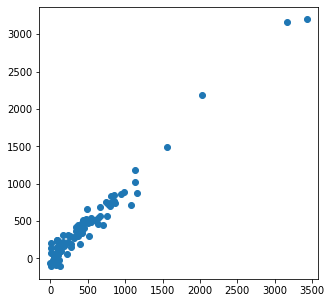

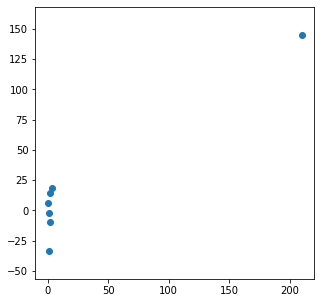

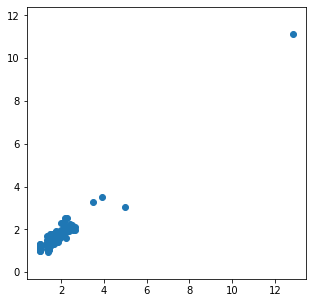

In [10]:
# see prediction results of other parameters
# note that all wikipedia data were inputted as "train" in this notebook 
targets= ['vapor pressure', 'viscosity', 'band gap', 
          'partition coefficient', 'molar heat capacity', 'thermal conductivity', 'dipole moment', 
          'pka', 'melting temperature', 'absolute molar magnetic susceptibility', 'density', 'boiling temperature', 
          'absolute standard enthalpy of formation', 'heat capacity', 'refractive index']

for target in targets:
    print(target)
    analyze(target=target,plotHeatMap=False,plotTest=False)

    print("\n")